In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import analysis as e2
from fxns import running_mean
from importlib import reload

In [2]:
colors = plt.cm.Set1.colors

def plot_reward(data_collection, labels, expt = 0, smoothing = 100, **kwargs):
    '''
    data_collection: datafilter class 
    TODO: need to specify which data --currently only training data
    '''
    title = kwargs.get('title', ' ')
    plt.figure()
    for i, sep in enumerate(data_collection):
        dat = sep.get_expt_data(expt_type=expt)
        for ii, d in enumerate(dat):
            if ii == 0:
                plt.plot(running_mean(d['total_reward'], smoothing), c=colors[i], label=labels[i])
            else:
                plt.plot(running_mean(d['total_reward'], smoothing), c=colors[i])
    plt.legend(bbox_to_anchor=(1.05,0.95))
    plt.title(title)
    plt.show()
    plt.close()
    

In [3]:
parent_dir = './data/'
df = pd.read_csv(parent_dir + 'experiments_log_old.csv')
experiment_types = ['Training',
                    'MF Only',
                    'EC ($\psi$)',
                    'EC ($\phi$)',
                    'MF Only (free)',
                    'EC ($\psi$)(free)',
                    'EC ($\phi$)(free)' ]

### Training

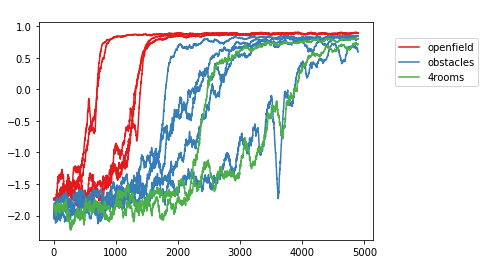

In [71]:
reload(e2)
# separate tasks:
openfield = e2.DataFilter(df, env_type=['None'], rho=[0.0])
obstacles = e2.DataFilter(df, env_type=['None'], rho=[0.1])
fourrooms = e2.DataFilter(df, env_type=['room'])
envs = [openfield, obstacles,fourrooms]
env_names = ['openfield', 'obstacles', '4rooms']
# plot 
plot_reward(envs, env_names, expt = 0 )

No handles with labels found to put in legend.
No handles with labels found to put in legend.


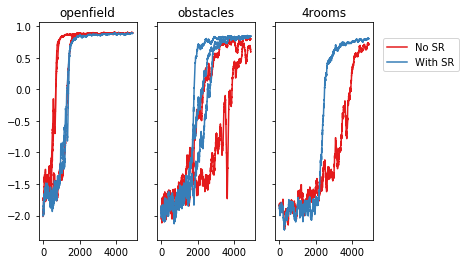

In [72]:
# show training by env type
fig, ax = plt.subplots(1,3, sharey=True)
smoothing = 100 
for j, task in enumerate(envs):
    title = env_names[j]
    A_ = e2.DataFilter(task.info, arch = ['A'])
    B_ = e2.DataFilter(task.info, arch = ['B'])

    data_collection = [A_, B_]
    labels = ['No SR', 'With SR']
    
    for i, sep in enumerate(data_collection):
        dat = sep.get_expt_data(expt_type=0)
        for ii, d in enumerate(dat):
            if ii == 0:
                ax[j].plot(running_mean(d['total_reward'], smoothing), c=colors[i], label=labels[i])
            else:
                ax[j].plot(running_mean(d['total_reward'], smoothing), c=colors[i])
    
    ax[2].legend(bbox_to_anchor=(1.05,0.95))
    ax[j].set_title(title)    
    
    
    #plot_reward(arch, ['A', 'B'], title=env_names[j], expt=0)
    #plot_reward(arch, ['A', 'B'], title=env_names[i], expt=4)

### Testing

MF Only


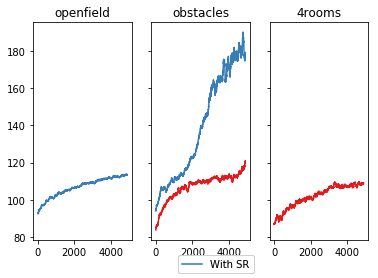

EC ($\psi$)


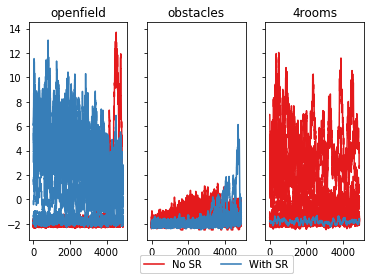

MF Only (free)


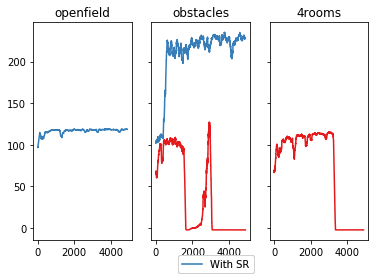

EC ($\psi$)(free)


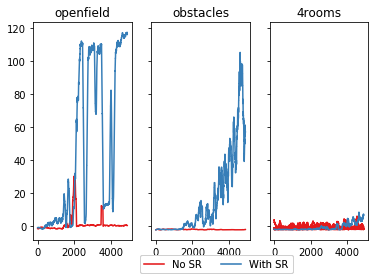

In [74]:
for test_expt in [1,2,4,5]:
    print(experiment_types[test_expt])
    fig, ax = plt.subplots(1,3, sharey=True)
    smoothing = 100 
    for j, task in enumerate(envs):
        title = env_names[j]
        A_ = e2.DataFilter(task.info, arch = ['A'])
        B_ = e2.DataFilter(task.info, arch = ['B'])

        data_collection = [A_, B_]
        labels = ['No SR', 'With SR']

        for i, sep in enumerate(data_collection):
            dat = sep.get_expt_data(expt_type=test_expt)
            for ii, d in enumerate(dat):
                if ii == 0 and j ==0:
                    ax[j].plot(running_mean(d['total_reward'], smoothing), c=colors[i], label=labels[i])
                else:
                    ax[j].plot(running_mean(d['total_reward'], smoothing), c=colors[i])

        fig.legend(loc='lower center', bbox_to_anchor=(0.5,0), ncol=2)
        ax[j].set_title(title)  
    plt.show()
    plt.close()

2/25 entries match criteria
21/25 entries match criteria


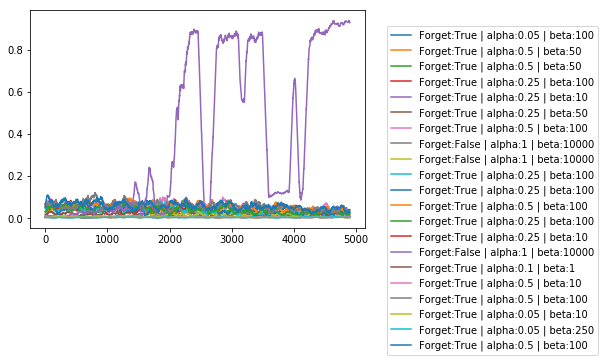

In [54]:
task = openfield

mf_only = e2.DataFilter(task.info,arch=['B'],expt_type=[1,4])
with_ec = e2.DataFilter(task.info,arch=['B'], expt_type=[2,5])
subtask = with_ec


lb = -2.5
ub = 125
smoothing = 100
for i in range(len(subtask.data)):
    #print(subtask.info.iloc[i])
    tag = f"Forget:{subtask.info.iloc[i]['use_pvals']} | alpha:{subtask.info.iloc[i]['alpha']} | beta:{subtask.info.iloc[i]['beta']}"
    x = running_mean((1/(ub-lb))*(np.asarray(subtask.data[i]['total_reward']) -lb), smoothing)
    plt.plot(x, label=tag)
#plt.ylim((0,1))
plt.legend(bbox_to_anchor=(1.05,0.95))
plt.show()

2/110 entries match criteria
5/110 entries match criteria
2


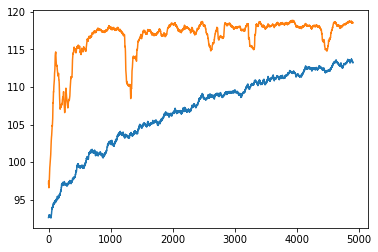

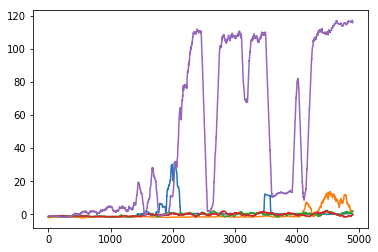

In [10]:
task = openfield

mf_only = e2.DataFilter(task.info, expt_type=[1,4])
with_ec = e2.DataFilter(task.info, expt_type=[2,5], beta=['10000'])

stuff = [mf_only, with_ec]
print(len(mf_only.data))
for i in mf_only.data:
    
    plt.plot(running_mean(i['total_reward'],100))
plt.show()
plt.close()

plt.figure()
for ii, i in enumerate(with_ec.data):
    
    plt.plot(running_mean(i['total_reward'], 100))
plt.show()
plt.close()

In [ ]:
for j in with_ec.info.columns:
    print(j)
    for ii in range(len(with_ec.data)):
        print(with_ec.info.loc[ii][j])
    print('======')

In [ ]:
import sys
import environment as gw 
sys.modules['gw'] = gw
import pickle
filename = './data/results/65d67225-ad1e-4b47-9d48-e3c1bb893028_data.p'
chx = pickle.load(open(filename, 'rb'))

In [4]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(chx['total_reward'])
print(chx['arbitration_count'][2])

In [5]:
## load specific record 7dea28aa-060a-4381-8bcc-c2639a4febd5
class single_record(object):
    def __init__(self, save_id):
        parent_dir = './data/'
        self.data = pickle.load(open(parent_dir + f'results/{save_id}_data.p', 'rb'))

In [6]:
a = single_record('a7586651-4903-4a72-9c7a-68d04e5af07b')

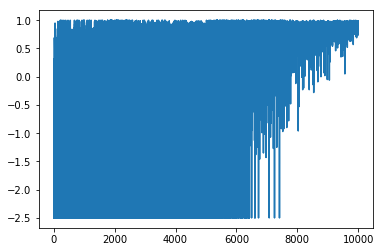

In [7]:
plt.plot(a.data['total_reward'])

In [75]:
alpha = 1
beta = 10000
threshold = 0.01
decay = np.power(threshold, 1/beta)

#mfcs = decay*old_mfcs + alpha*last_reward
weight = 0.01
#some_rewards = [np.random.choice([0,1], p=[1-weight, weight]) for _ in range(100)]
def plot_decay(alpha,beta):
    threshold = 0.01
    decay = np.power(threshold, 1/beta)
    
    number_ = 500 
    #r = np.ones(number_)*(-0.5)
    #r[0]=alpha
    r = [np.random.choice([-0.01,1], p=[1-weight, weight]) for _ in range(number_)]
    mfcs = []
    mfcs.append(0)
    for num in range(number_):
        step = r[num]
        if step <0:
            step = 0 
        cs = decay*mfcs[num] + alpha*step
        if cs>1:
            cs =1
        elif cs<0:
            cs=0
        mfcs.append(cs)
    plt.plot(r,'r|')
    plt.plot(mfcs)

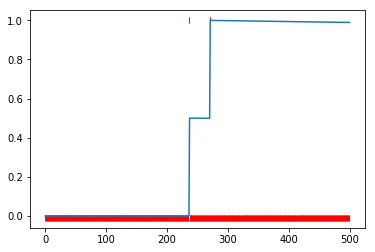

In [80]:
plot_decay(0.5,100000)